## Data Acquisition

In [1]:
from os import listdir
from os.path import isfile, join

import pandas as pd

In [2]:
def merge_dataset(data_files: str = "../datasets", symbol: str = "btc"):
    files = [f for f in listdir(data_files) if isfile(join(data_files, f)) and f.startswith(symbol) and f.endswith('.parquet')]
    return pd.concat(
        pd.read_parquet(join(data_files, f), engine='fastparquet') for f in files
    )

In [3]:
def prepare_dataset(data_files: str = "../datasets", symbol: str = "btc", datetime_index: bool = True):
    df = merge_dataset(data_files=data_files, symbol=symbol)
    
    # timestamp to python datetime
    if datetime_index:
        df['date'] = pd.to_datetime(df['date'], unit='s')

    df = df.set_index(['date'])
    df.sort_index(inplace=True)

    return df

In [4]:
btc_trades_df = prepare_dataset()

In [5]:
btc_trades_df.head()

,type,price,amount
date,,,
2013-06-12 08:39:21,buy,249.0,0.381000
2013-06-12 10:34:30,buy,249.0,0.020000
2013-06-12 16:16:07,buy,249.0,3.564896
2013-06-12 16:16:07,buy,249.0,1.387382
2013-06-12 16:43:47,buy,260.0,0.130480


In [6]:
btc_trades_df.tail()

,type,price,amount
date,,,
2024-03-24 22:47:10,buy,336286.893944,0.000006
2024-03-24 22:47:18,buy,336347.116719,0.000004
2024-03-24 22:47:32,sell,336062.300849,0.000816
2024-03-24 22:47:42,sell,336062.300899,0.000191
2024-03-24 22:47:52,sell,335797.000000,0.000006


In [7]:
btc_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16529676 entries, 2013-06-12 08:39:21 to 2024-03-24 22:47:52
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   type    object 
 1   price   float64
 2   amount  float64
dtypes: float64(2), object(1)
memory usage: 504.4+ MB


In [8]:
btc_trades_df.describe()

,price,amount
count,1.652968e+07,1.652968e+07
mean,1.421893e+05,3.605958e-02
std,1.111363e+05,1.918438e-01
min,0.000000e+00,0.000000e+00
25%,3.781700e+04,7.283800e-04
50%,1.209170e+05,3.506680e-03
75%,2.319979e+05,1.746010e-02
max,3.800000e+05,6.600000e+01


## Exploratory Data Analysis

In [9]:
# TBD

## Models

### Isolation Forest

In [10]:
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [41]:
#initiate the model with 5% contamination

model_year = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

#### 1 year dataset

In [45]:
df_year = btc_trades_df.loc['2023-01-01':'2023-12-31'][['price', 'amount']]

In [46]:
model_year.fit(df_year)

IsolationForest(contamination=0.05, n_estimators=1000, n_jobs=-1,
                random_state=139)

In [47]:
df_year['score'] = model_year.decision_function(df_year[['price', 'amount']])
df_year['anomaly_value'] = model_year.predict(df_year[['price', 'amount']])

anomaly_value
 1    1218003
-1      64106
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

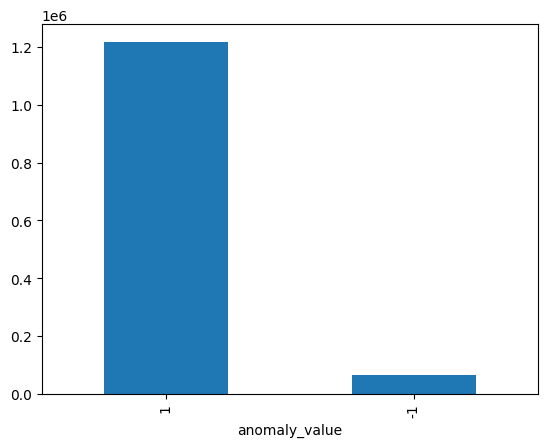

In [48]:
# outliers
outliers_year = df_year.loc[df_year['anomaly_value'] == -1]
outlier_index = list(outliers_year.index)

#datapoints classified -1 are anomalous
print(df_year['anomaly_value'].value_counts())
df_year['anomaly_value'].value_counts().plot(kind = 'bar')

In [49]:
outliers_year

,price,amount,score,anomaly_value
date,,,,
2023-01-01 00:07:22,87967.510750,0.014892,-0.024422,-1
2023-01-01 00:08:02,88198.421493,0.007374,-0.002930,-1
2023-01-01 00:10:51,88184.323920,0.008733,-0.008754,-1
2023-01-01 00:11:28,88181.242159,0.008982,-0.009848,-1
2023-01-01 01:22:32,87946.900000,0.181366,-0.163236,-1
...,...,...,...,...
2023-12-31 22:51:57,209260.000000,0.050840,-0.080444,-1
2023-12-31 22:52:01,208748.701024,0.044913,-0.072680,-1
2023-12-31 22:52:01,208696.035409,0.026200,-0.035155,-1


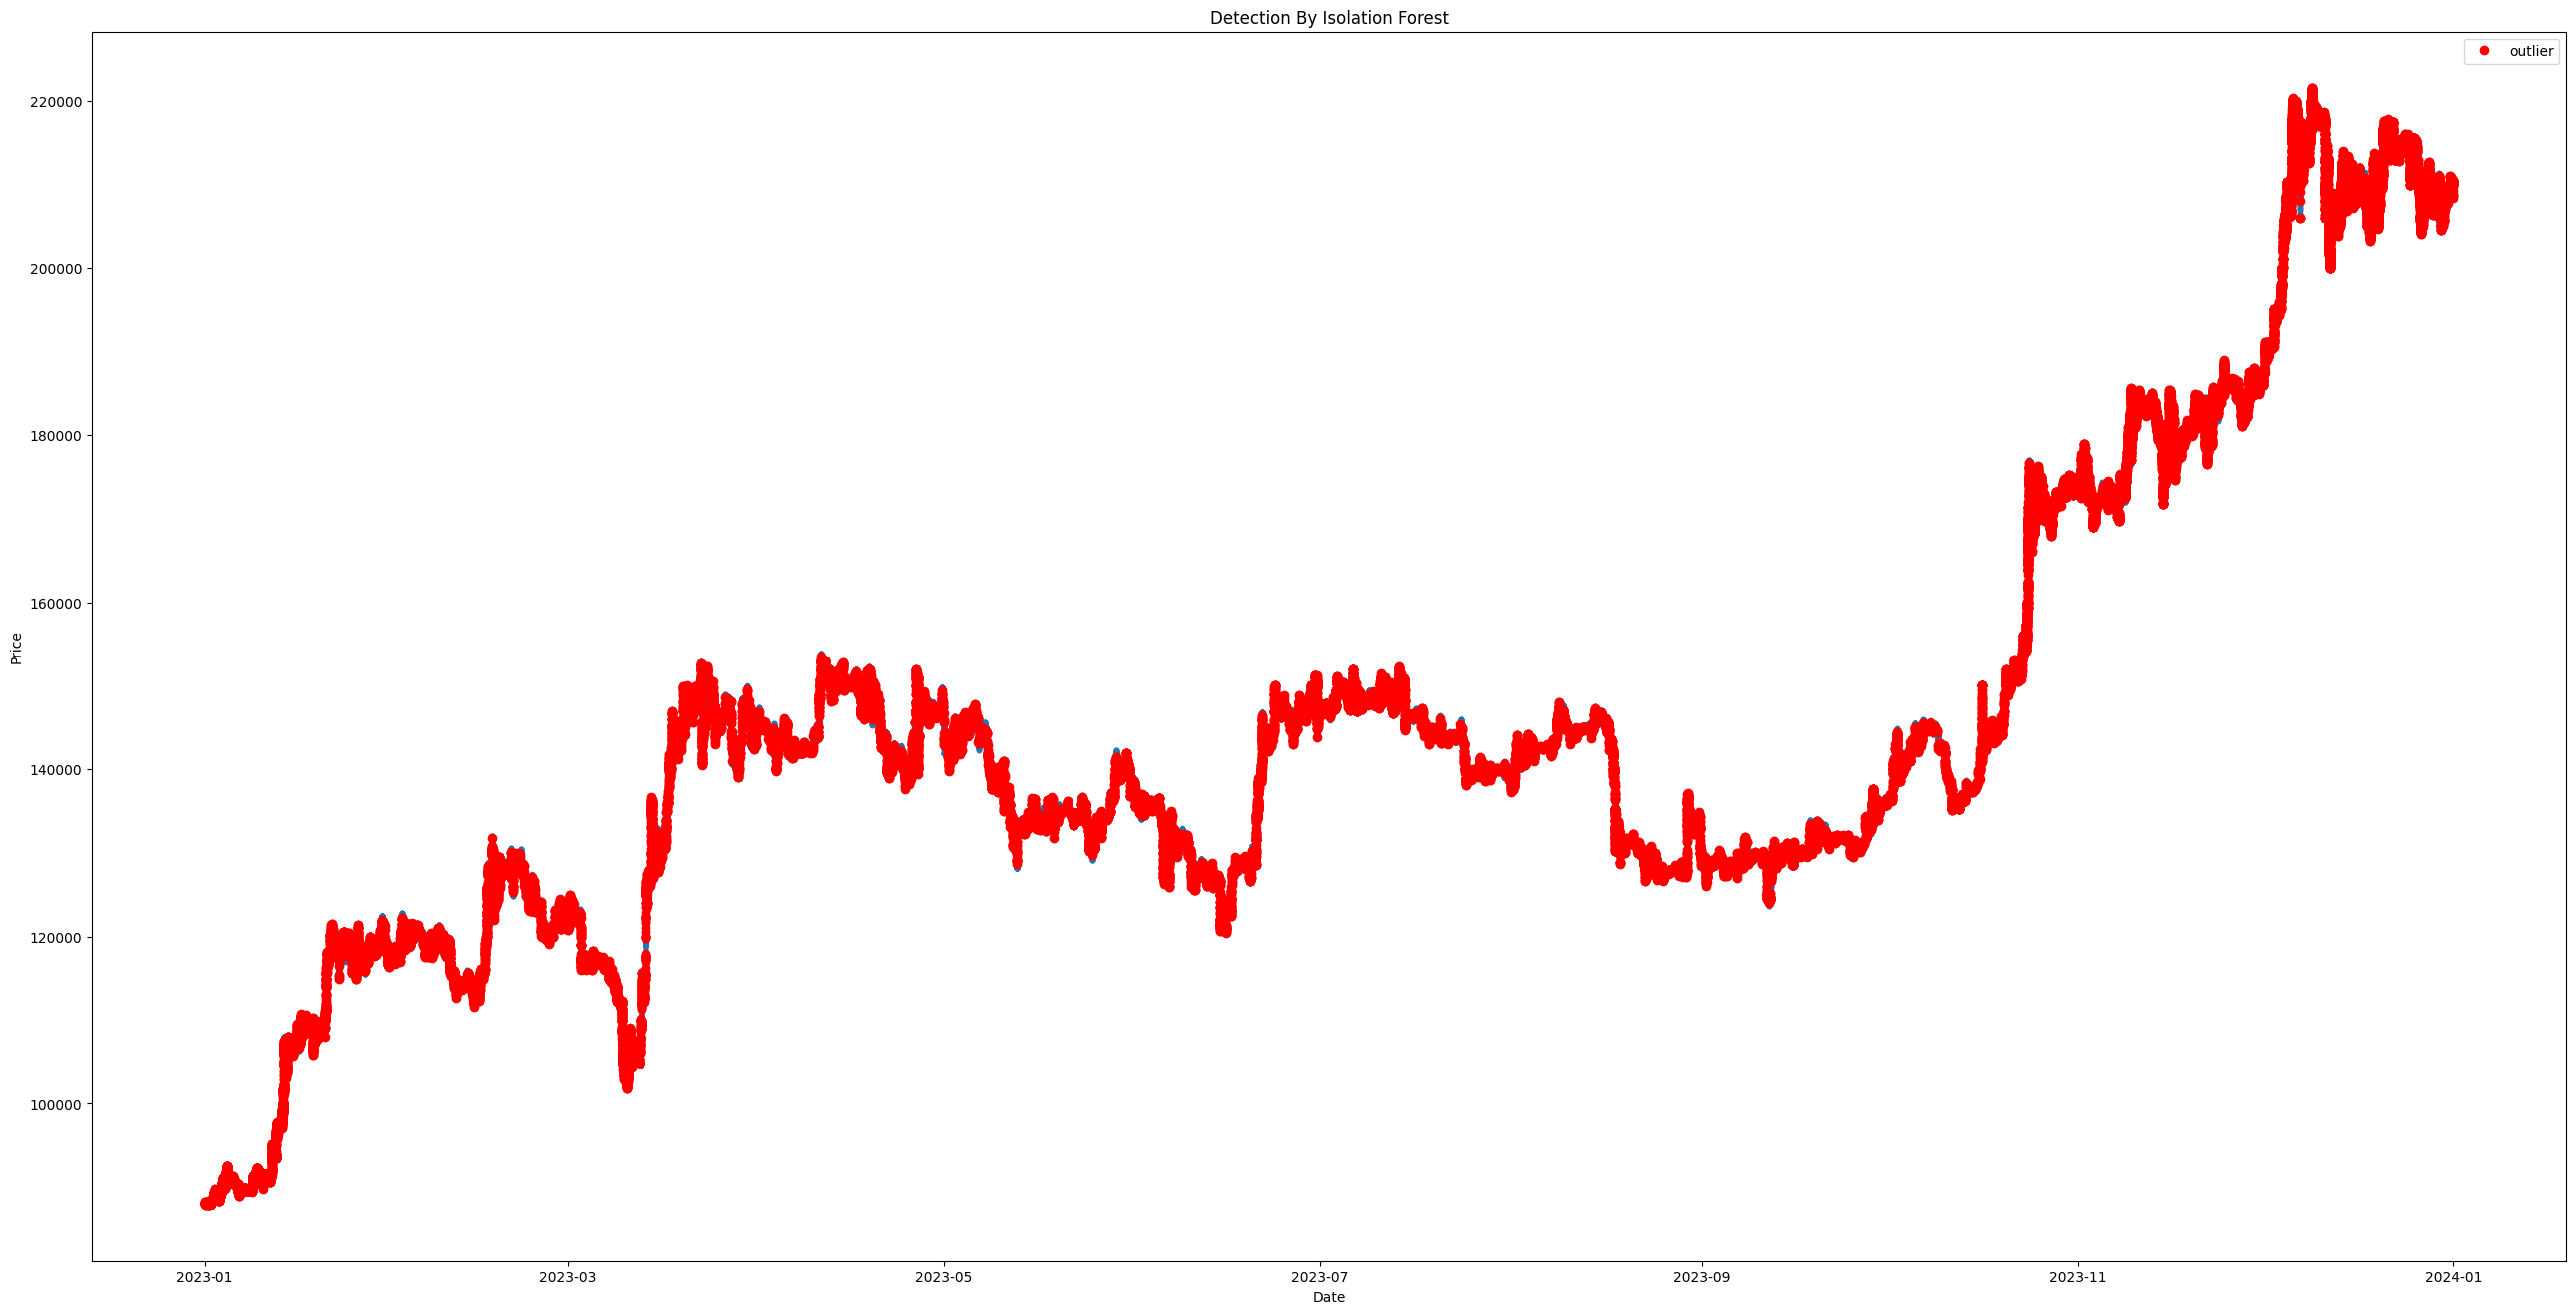

In [50]:
plt.figure(figsize = (32, 16))

plt.plot(df_year[['price']], marker = '.')
plt.plot(outliers_year[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [18]:
import plotly.express as px
import plotly.graph_objects as go

In [19]:
# fig = px.line(df_year_2023, x=df_year_2023.index, y="price")
# fig.add_trace(go.Scatter(mode="markers", x=outliers.index, y=outliers["price"], name="outliers"))

#### 1 month dataset

In [53]:
df_month = btc_trades_df.loc['2024-01-01':'2024-01-31'][['price', 'amount']]

In [54]:
#initiate the model with 5% contamination

model_month = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

In [55]:
model_month.fit(df_month)
df_month['score'] = model_month.decision_function(df_month[['price', 'amount']])
df_month['anomaly_value'] = model_month.predict(df_month[['price', 'amount']])

anomaly_value
 1    180684
-1      9510
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

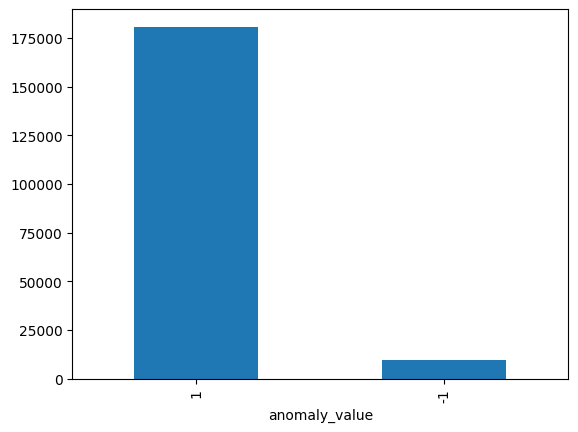

In [56]:
# outliers
outliers_month = df_month.loc[df_month['anomaly_value'] == -1]
outlier_index_month = list(outliers_month.index)

#datapoints classified -1 are anomalous
print(df_month['anomaly_value'].value_counts())
df_month['anomaly_value'].value_counts().plot(kind = 'bar')

In [57]:
outliers_month

,price,amount,score,anomaly_value
date,,,,
2024-01-01 02:13:09,210244.00005,0.099723,-0.081672,-1
2024-01-01 02:49:47,210244.00005,0.057695,-0.019901,-1
2024-01-01 02:49:50,210244.00005,0.057695,-0.019901,-1
2024-01-01 02:49:55,210018.00000,0.064766,-0.036272,-1
2024-01-01 03:52:45,209155.00000,0.105659,-0.090620,-1
...,...,...,...,...
2024-01-31 22:45:32,212139.40000,0.127859,-0.100639,-1
2024-01-31 23:25:56,212394.68000,0.250000,-0.167940,-1
2024-01-31 23:33:10,212329.87000,0.057207,-0.013338,-1


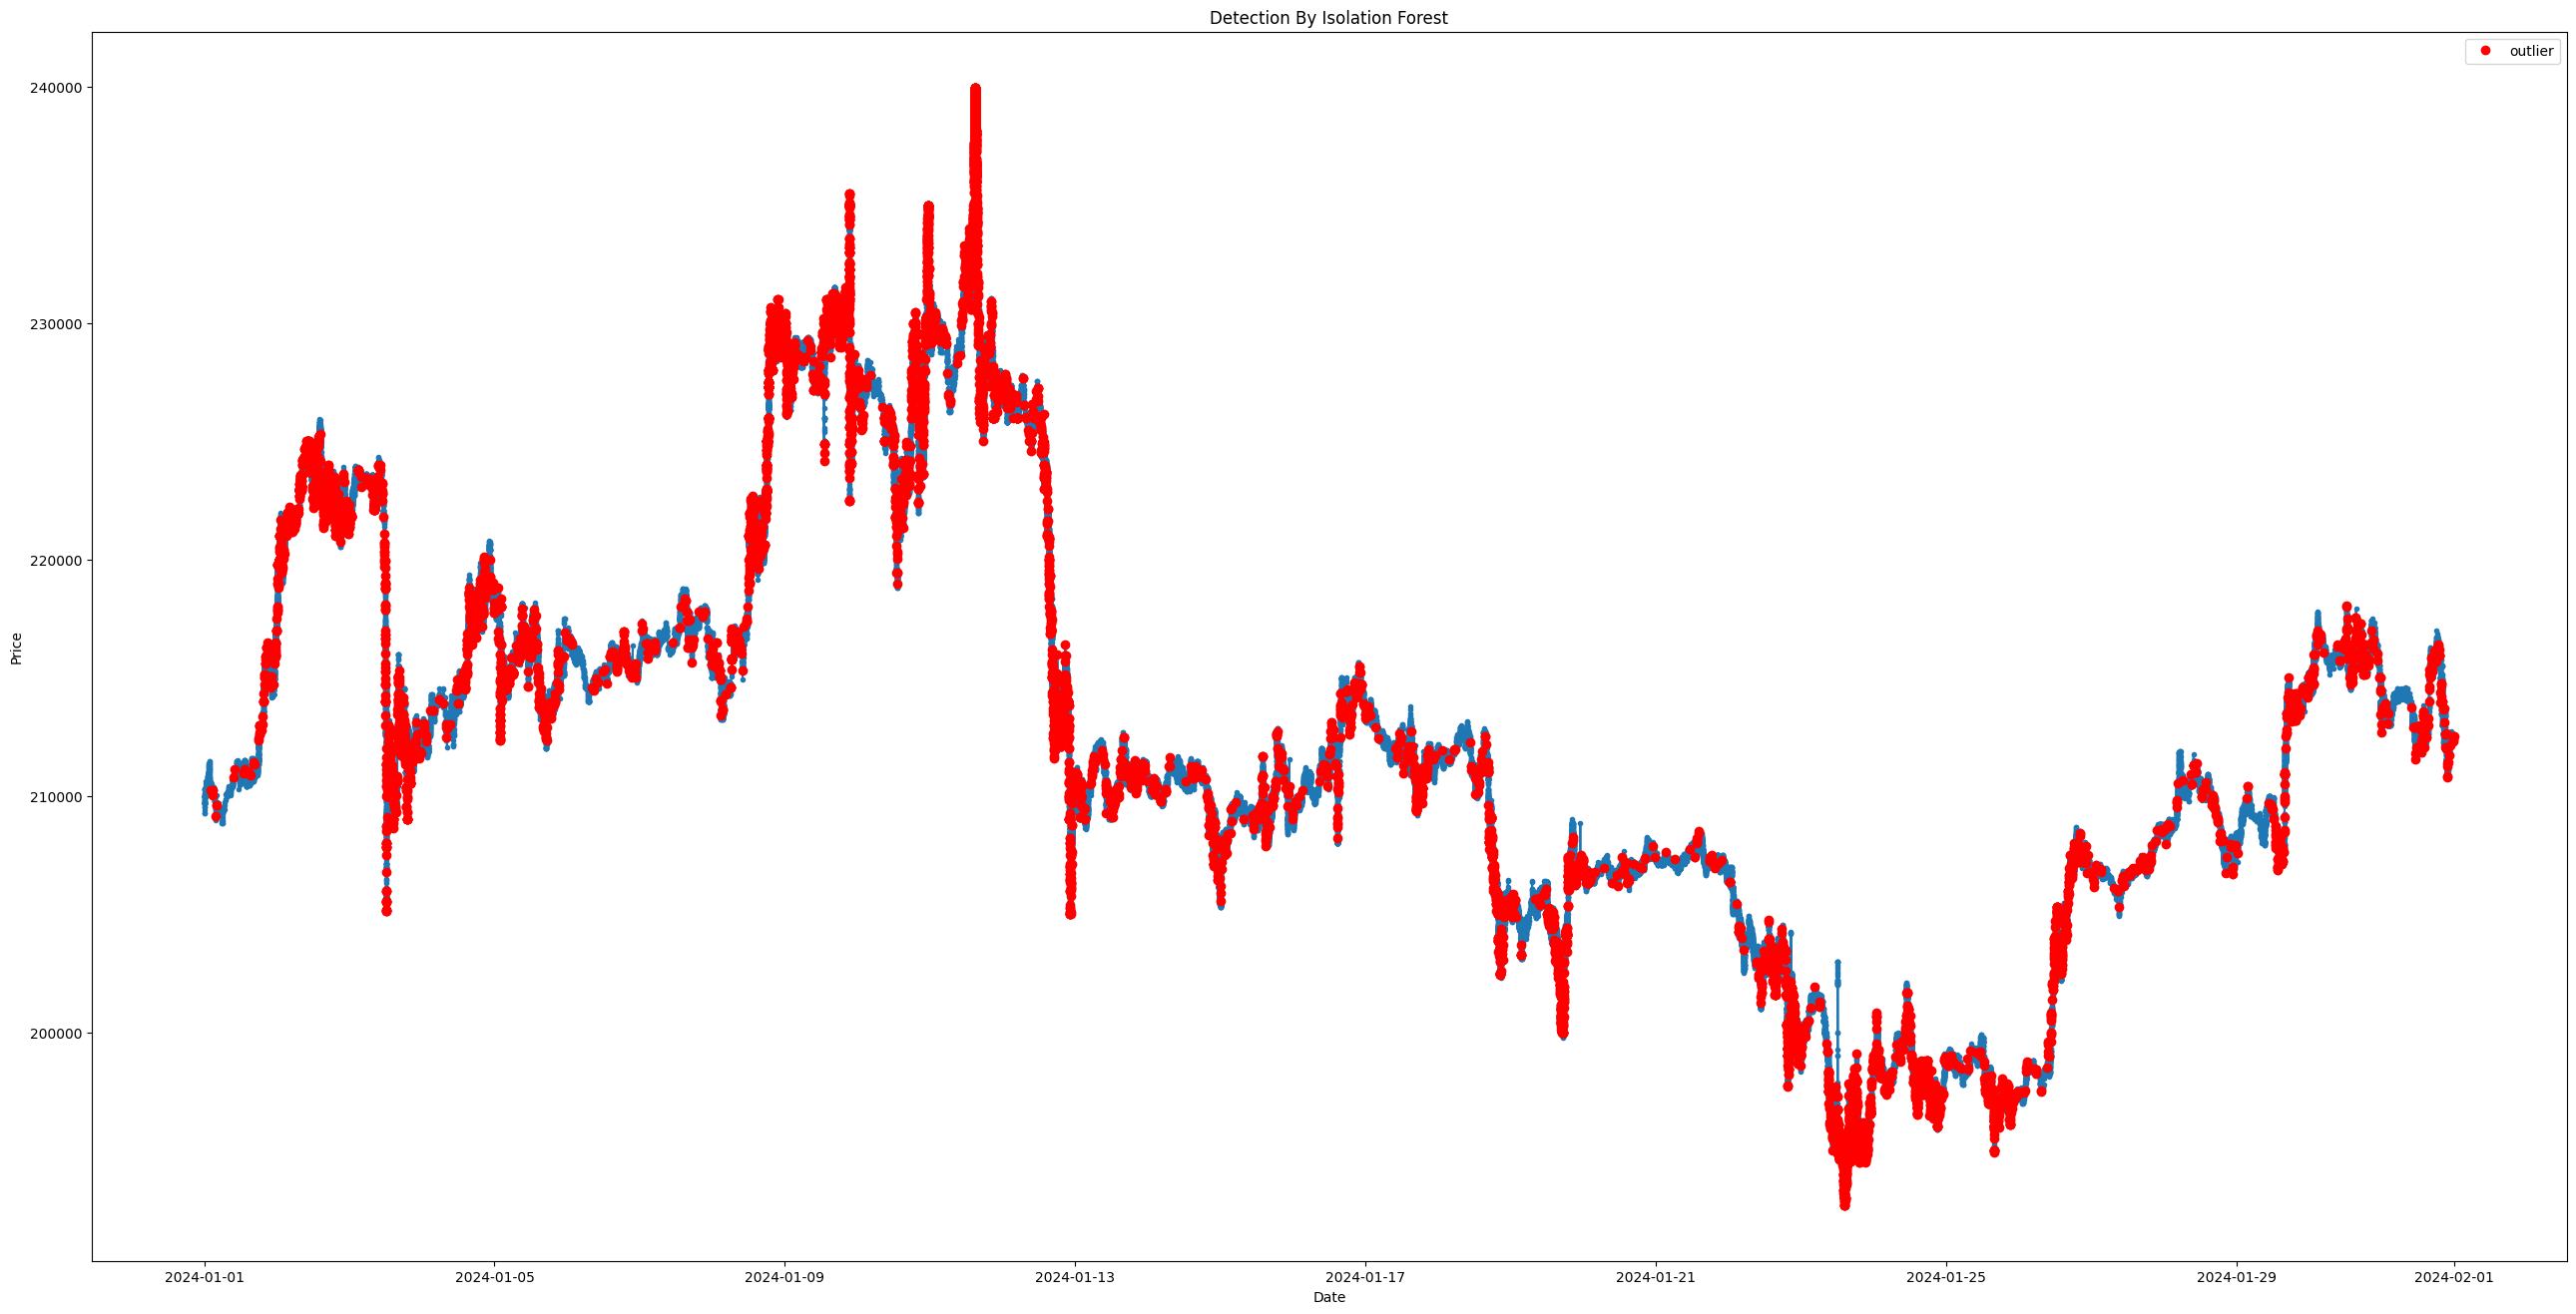

In [58]:
plt.figure(figsize = (32, 16))

plt.plot(df_month[['price']], marker = '.')
plt.plot(outliers_month[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### 1 day dataset

In [59]:
df_day = btc_trades_df.loc['2024-03-24':'2024-03-24'][['price', 'amount']]

In [60]:
df_day

,price,amount
date,,
2024-03-24 00:00:36,323071.042641,0.000006
2024-03-24 00:01:17,323000.000212,0.001144
2024-03-24 00:02:43,323000.000050,0.030853
2024-03-24 00:02:43,323071.040000,0.000315
2024-03-24 00:02:58,323361.175712,0.000010
...,...,...
2024-03-24 22:47:10,336286.893944,0.000006
2024-03-24 22:47:18,336347.116719,0.000004
2024-03-24 22:47:32,336062.300849,0.000816


In [61]:
#initiate the model with 5% contamination

model_day = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

In [62]:
model_day.fit(df_day)
df_day['score'] = model_day.decision_function(df_day[['price', 'amount']])
df_day['anomaly_value'] = model_day.predict(df_day[['price', 'amount']])

anomaly_value
 1    3473
-1     183
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

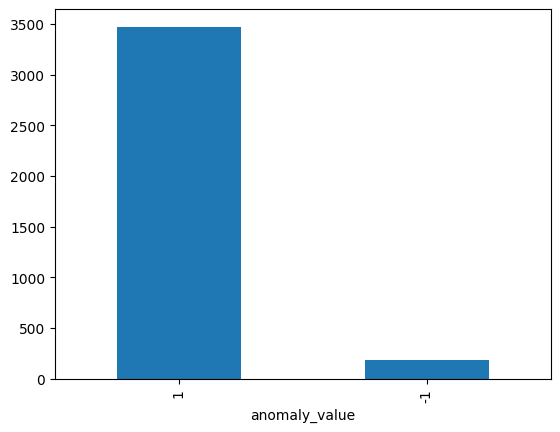

In [30]:
# outliers
outliers_day = df_day.loc[df_day['anomaly_value'] == -1]
outlier_index_day = list(outliers_day.index)

#datapoints classified -1 are anomalous
print(df_day['anomaly_value'].value_counts())
df_day['anomaly_value'].value_counts().plot(kind = 'bar')

In [63]:
outliers_day

,price,amount,score,anomaly_value
date,,,,
2024-03-24 00:02:43,323000.000050,0.030853,-0.149353,-1
2024-03-24 00:09:05,323881.199277,0.006700,-0.015931,-1
2024-03-24 00:09:05,323952.292282,0.015030,-0.078066,-1
2024-03-24 00:10:38,323992.573136,0.006700,-0.013931,-1
2024-03-24 00:10:38,324036.980000,0.017765,-0.089135,-1
...,...,...,...,...
2024-03-24 22:39:22,336262.670000,0.006724,-0.006262,-1
2024-03-24 22:43:49,336711.670000,0.004082,-0.022449,-1
2024-03-24 22:45:23,336711.670000,0.028018,-0.119657,-1


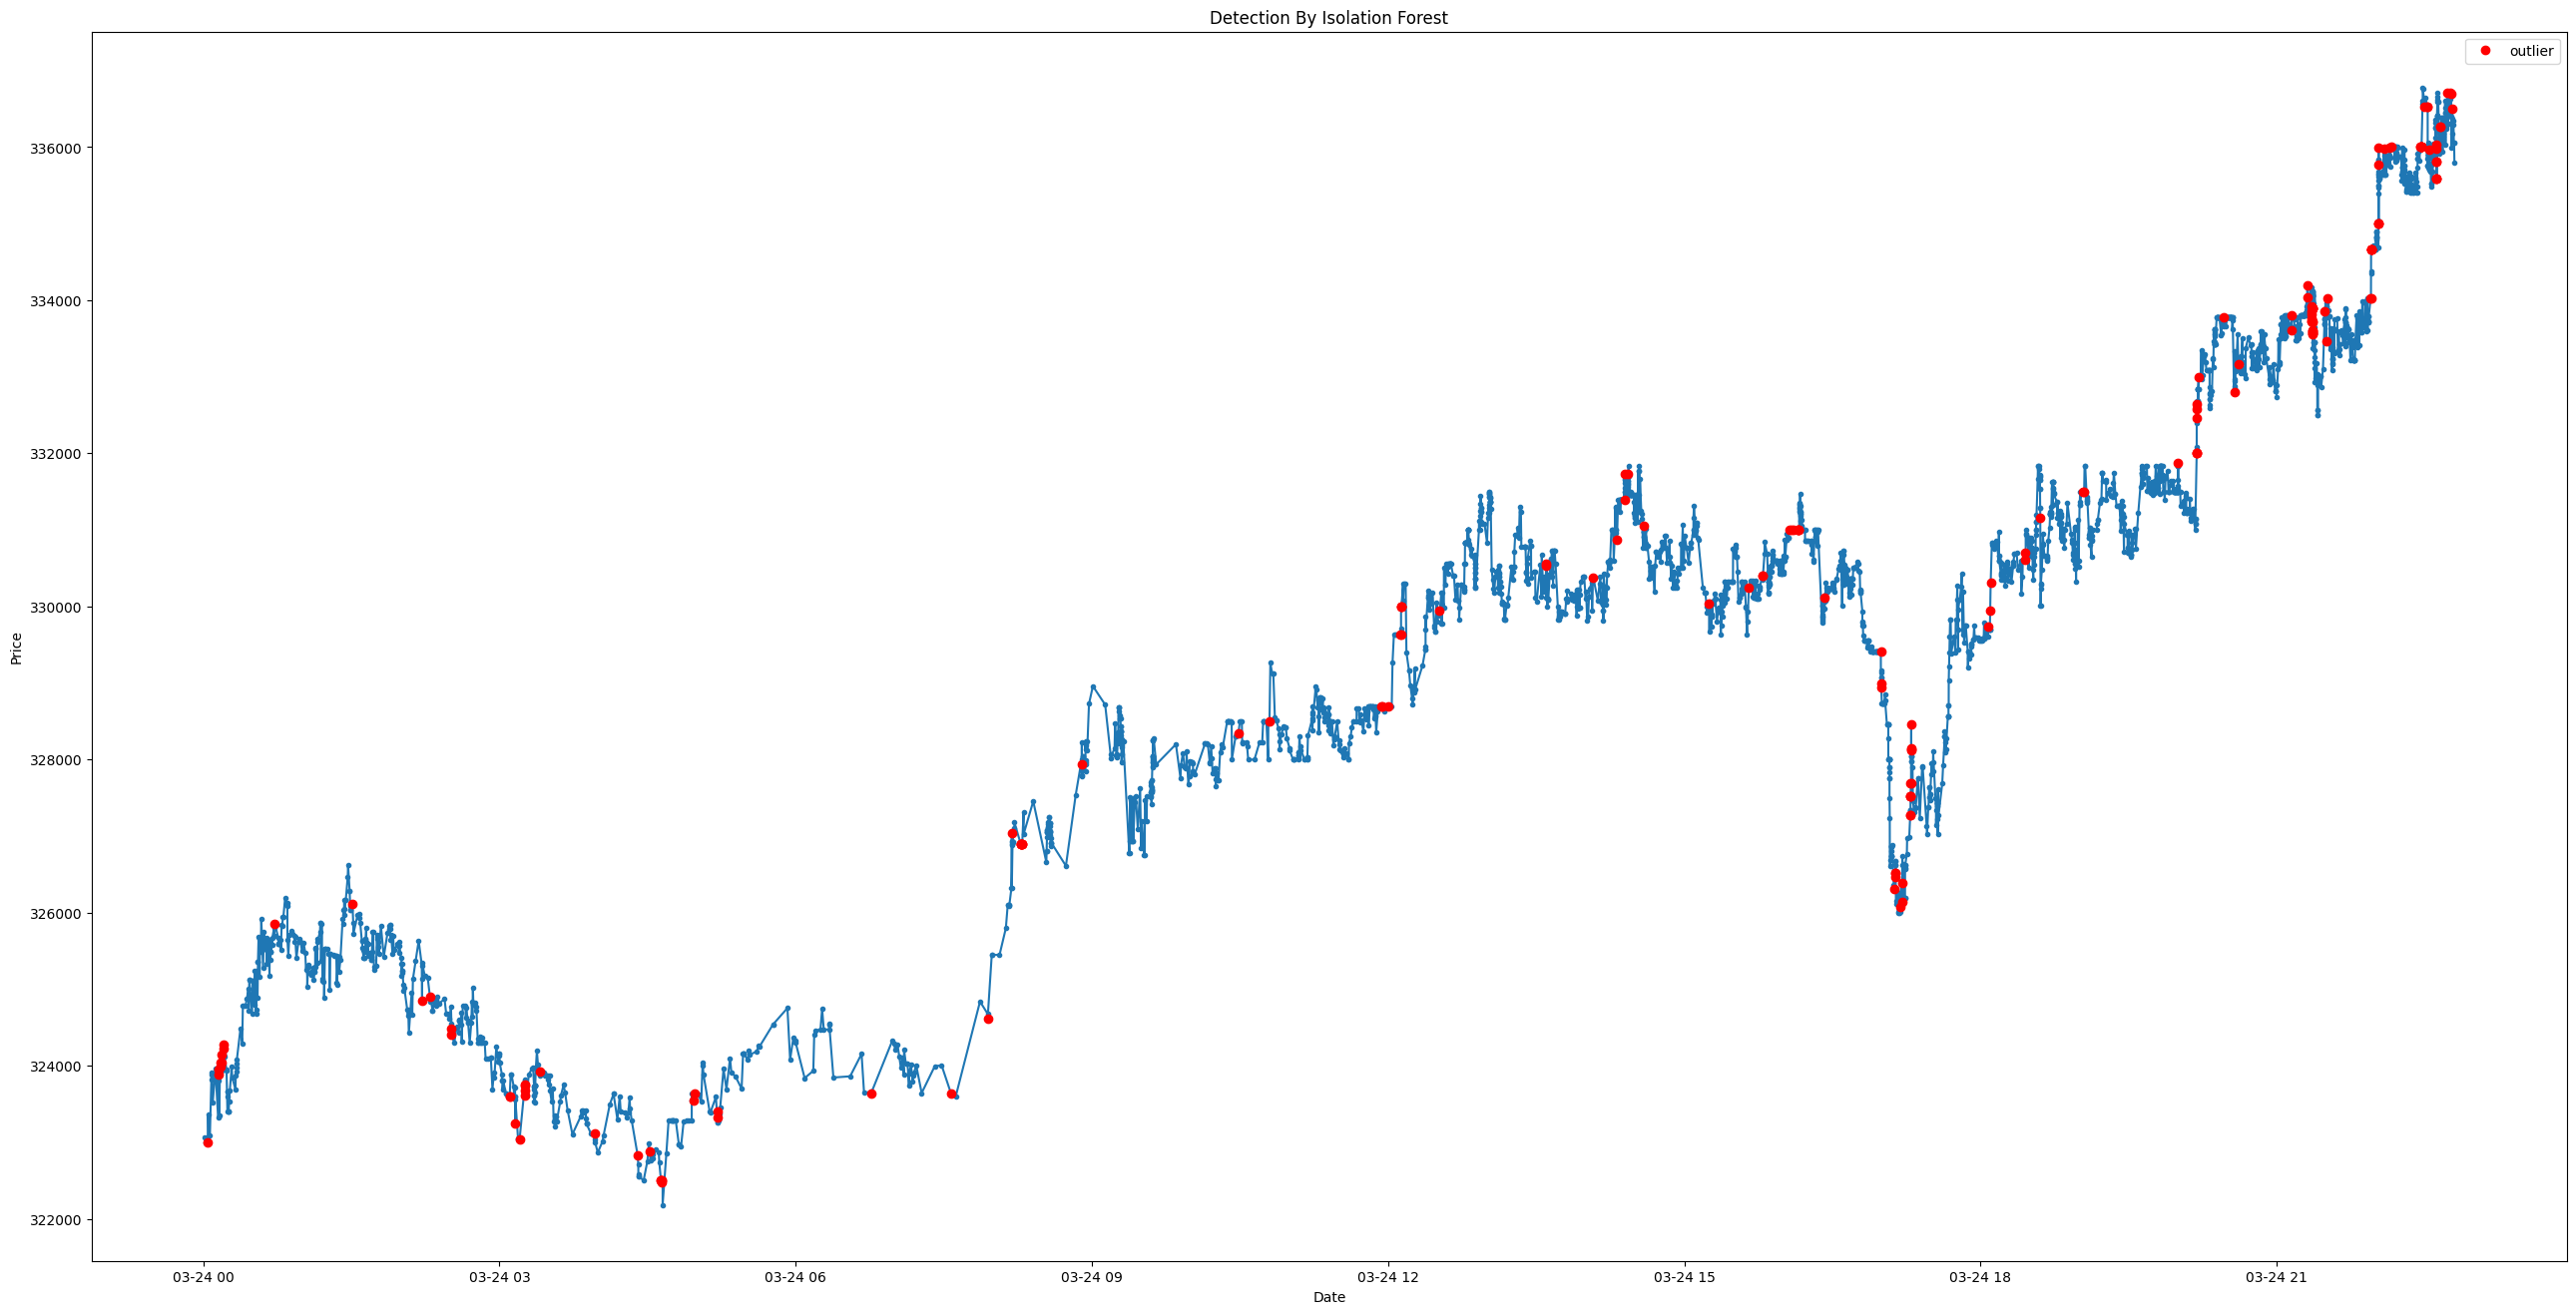

In [64]:
plt.figure(figsize = (32, 16))

plt.plot(df_day[['price']], marker = '.')
plt.plot(outliers_day[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### 1 hour dataset

In [65]:
df_hour = btc_trades_df.loc['2024-03-24 17:00:00':'2024-03-24 17:59:59'][['price', 'amount']]

In [66]:
df_hour

,price,amount
date,,
2024-03-24 17:00:17,328734.792057,0.000740
2024-03-24 17:00:17,328734.800000,0.002090
2024-03-24 17:00:32,328734.800000,0.000013
2024-03-24 17:00:37,328734.800000,0.000003
2024-03-24 17:00:54,328734.800000,0.000054
...,...,...
2024-03-24 17:56:54,329587.656897,0.000570
2024-03-24 17:57:13,329591.370000,0.000055
2024-03-24 17:58:30,329591.370000,0.000029


In [67]:
#initiate the model with 1% contamination

model_hour = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.01),
    random_state=139,
    n_jobs=-1
)

In [68]:
model_hour.fit(df_hour)
df_hour['score'] = model_hour.decision_function(df_hour[['price', 'amount']])
df_hour['anomaly_value'] = model_hour.predict(df_hour[['price', 'amount']])

anomaly_value
 1    201
-1      3
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

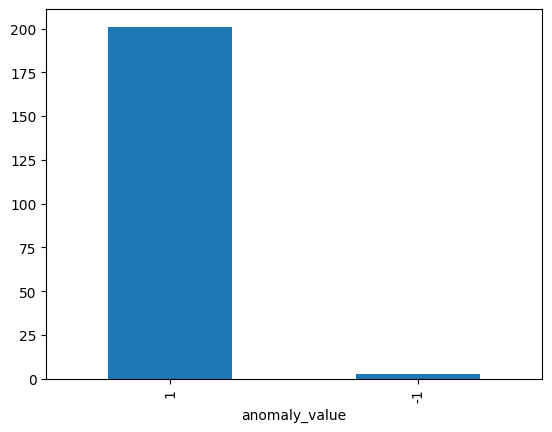

In [69]:
# outliers
outliers_hour = df_hour.loc[df_hour['anomaly_value'] == -1]
outlier_index_h = list(outliers_hour.index)

#datapoints classified -1 are anomalous
print(df_hour['anomaly_value'].value_counts())
df_hour['anomaly_value'].value_counts().plot(kind = 'bar')

In [70]:
outliers_hour

,price,amount,score,anomaly_value
date,,,,
2024-03-24 17:17:26,327522.0,0.193945,-0.050585,-1
2024-03-24 17:17:31,327522.0,0.181473,-0.042437,-1
2024-03-24 17:17:31,327686.0,0.074625,-0.001113,-1


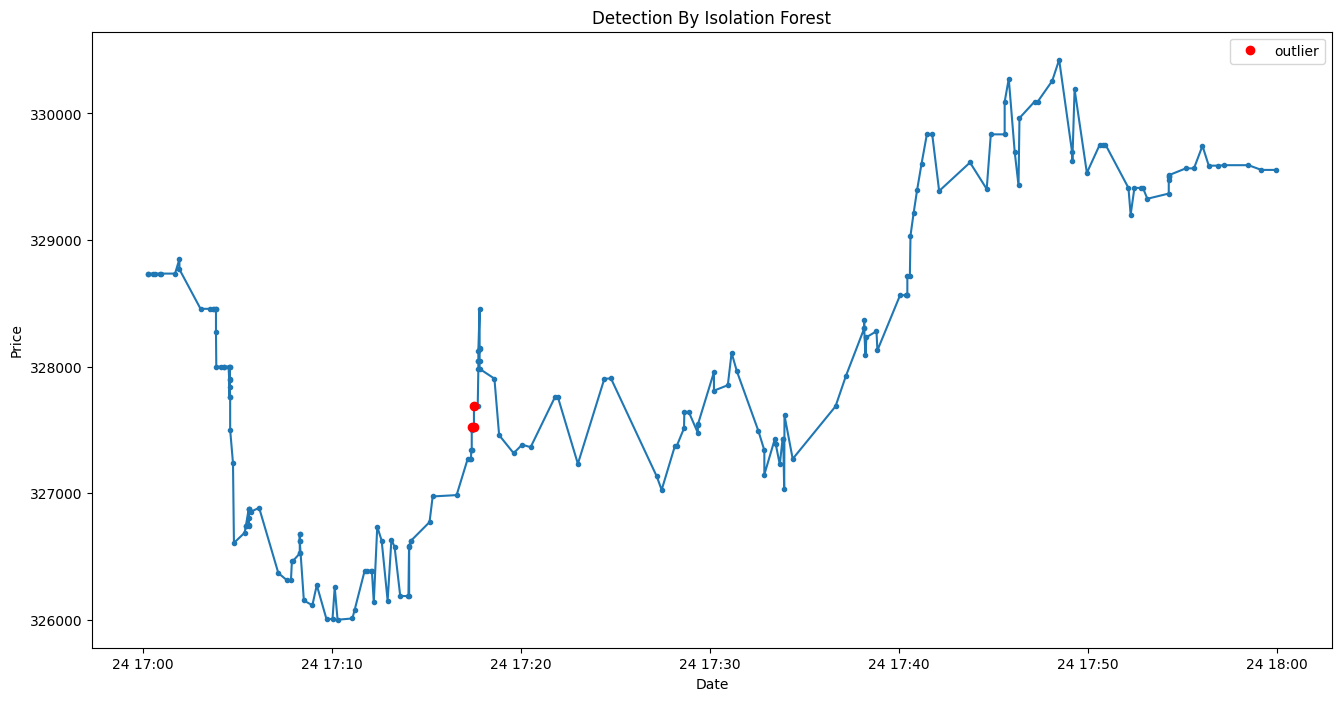

In [71]:
plt.figure(figsize = (16, 8))

plt.plot(df_hour[['price']], marker = '.')
plt.plot(outliers_hour[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Isolation Forest - Day')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()